In [2]:
from astropy.io import fits
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ckdtree as kdtree 
import itertools
%matplotlib inline

In [3]:
#read in TGAS data for and matched sample for magnitudes 
tgas = fits.getdata("stacked_tgas.fits", 1)
tgasRave = fits.getdata('tgas-rave.fits', 1)
matchTgasApass = fits.getdata('tgas-matched-apass-dr9.fits')

In [4]:
#print tgasRave.dtype.names
#print tgas.dtype.names
#print matchTgasApass.dtype.names

In [5]:
raveInd = np.in1d(tgas['source_id'], tgasRave['source_id'])

In [6]:
#print np.array(tgas.dtype.names).T
#print np.array(tgasRave.dtype.names).T

In [7]:
#read in Adrian's distances from sampling the posterior 
ndist = 100
nfiles = 16
dist = None #np.zeros(len(tgasMatched), ndist)
for j in range(1,nfiles+1):
    with h5py.File("distance-samples-{:02d}.hdf5".format(j)) as f:
        if dist is None:
            dist = f['distance'][:,:ndist]
        else:
            dist = np.concatenate((dist, f['distance'][:,:ndist]))

In [8]:
#calculate the median distance from the posterior 
medianDist = np.median(dist, axis=1)

In [9]:
#various cuts to select sample 
proj = 'twins'
ndist = ndist
nNeighbors = 10
sigMax = 0.1
maxDist = 8000. #1000. #pc
fracErrorDistance = 1.

if proj ==  'twins':
    minDist = 0.0 #pc
    parallaxSN = 16.
    galacticLatMin = 30. #degrees
    galacticLatMax = None #degrees
if proj == 'dust':
    minDist = 250. #pc
    parallaxSN = 5.
    galacticLatMin = 0.  #degrees 
    galacticLatMax = 10. #degrees
    
mags = ['bmag', 'gmag', 'vmag', 'rmag', 'imag']
errors = ['e_bmag', 'e_gmag', 'e_vmag', 'e_rmag', 'e_imag']
wavelength = [420., 475., 520., 658., 806.]

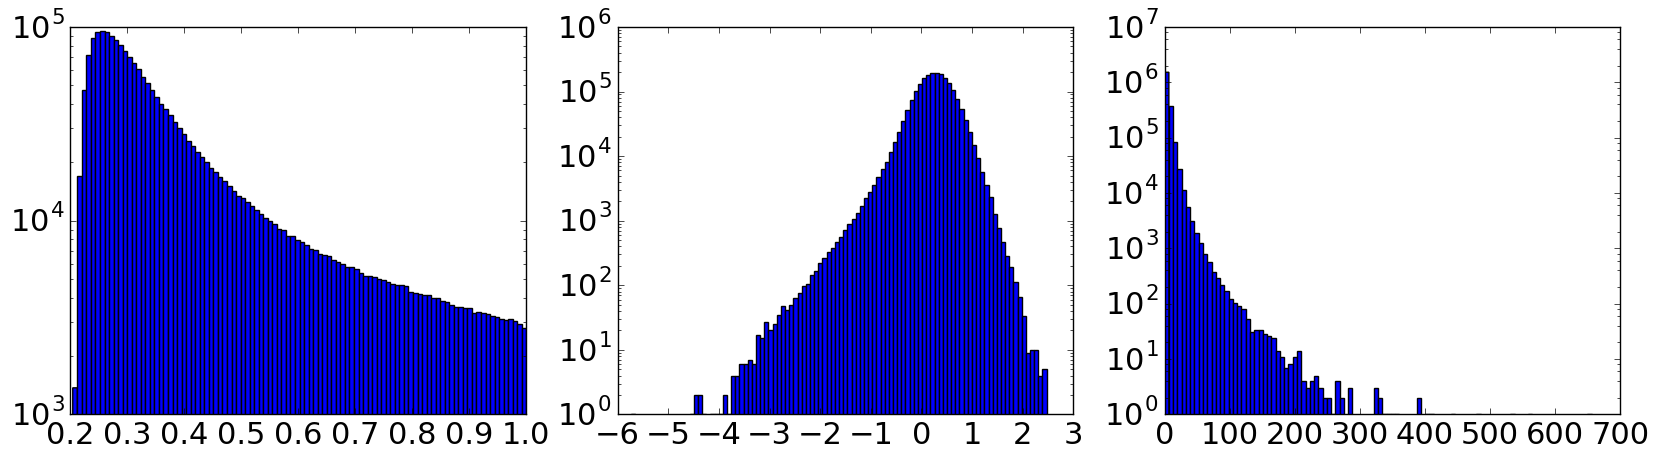

In [10]:
#visualize historgrams of parallax errors 
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(1, 3, figsize=(20,5))
notNan = ~np.isnan(tgas['parallax']) & (tgas['parallax'] > 0.0)
nbins=100
err = np.sqrt(tgas['parallax_error']**2. + 0.3**2.)
out = axes[0].hist(tgas['parallax_error'][notNan], log=True, bins=nbins)
out = axes[1].hist(np.log10(tgas['parallax'][notNan]), log=True, bins=nbins)
out = axes[2].hist(tgas['parallax'][notNan]/err[notNan], log=True, bins=nbins)

In [11]:
#current cut: no magnitudes are NaNs, 0 < errors < sigMax, 
#print np.sum(tgas['parallax']/err > parallaxSN)

noNans = ~np.isnan(matchTgasApass['bmag']) & ~np.isnan(matchTgasApass['vmag']) & \
         ~np.isnan(matchTgasApass['gmag']) & ~np.isnan(matchTgasApass['rmag']) & \
         ~np.isnan(matchTgasApass['imag'])

posErrors = (matchTgasApass['e_bmag'] >= 0) & (matchTgasApass['e_vmag'] >= 0) & \
            (matchTgasApass['e_gmag'] >= 0) & (matchTgasApass['e_rmag'] >= 0) & \
            (matchTgasApass['e_imag'] >= 0)

lowPhotError = (matchTgasApass['e_bmag'] < sigMax) & (matchTgasApass['e_vmag'] < sigMax) & \
               (matchTgasApass['e_gmag'] < sigMax) & (matchTgasApass['e_rmag'] < sigMax) & \
               (matchTgasApass['e_imag'] < sigMax)

noDust = (medianDist < maxDist) & (np.abs(tgas['b']) > galacticLatMin)

apassMatch = matchTgasApass['matched']

goodDistance = tgas['parallax']/err > parallaxSN

hasDust = medianDist >= minDist

raveInd = raveInd

if galacticLatMax: inDisk = np.abs(tgas['b'] <= galacticLatMax)

matched = goodDistance & noNans & posErrors & lowPhotError & noDust & apassMatch & raveInd

/mnt/xfs1/scda_software/pkg/devel/python/2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater_equal
/mnt/xfs1/scda_software/pkg/devel/python/2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less


In [12]:
tgasMatched = tgas[matched]
magsMatched = matchTgasApass[matched]
errMatched = err[matched]

In [13]:
print 'Number of tgas stars: ', len(tgas)
print 'Number of matched stars: ', np.sum(matched)
print 'Percent matched = ', 100 - (len(tgas) - np.sum(matched))/np.float(len(tgas))*100., '%'
#print np.min(magsMatched['gmag']), np.max(magsMatched['gmag'])

Number of tgas stars:  2057050
Number of matched stars:  2035
Percent matched =  0.0989280766146 %


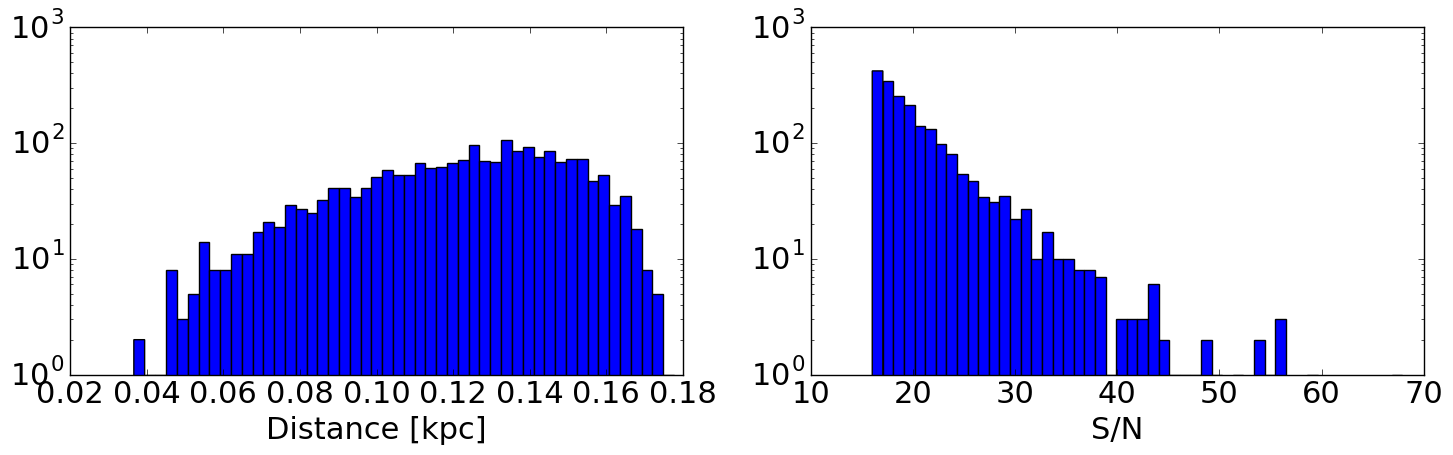

In [14]:
distMatched = dist[matched]
distUnmatched = dist[~matched]
medianDistMatched = np.median(distMatched, axis=1)
meanDistMatched = np.mean(distMatched, axis=1)
medianDistUnmatched = np.median(distUnmatched, axis=1)
fig, axes = plt.subplots(1,2, figsize=(15, 5))
out = axes[0].hist(medianDistMatched/1000., bins=50, log=True)
out = axes[1].hist(tgas['parallax'][matched]/err[matched], bins=50, log=True)
#out = axes[1].hist(np.log10(tgasMatched['parallax_error']))
#out = axes[1].hist(magsMatched['gmag'], bins=50, log=True)
axes[0].set_xlabel('Distance [kpc]')
axes[1].set_xlabel('S/N')
plt.tight_layout()
fig.savefig('distanceTgas.png')

In [15]:
def absMag(apparentMag, distance):
    return apparentMag - 5.*np.log10(distance/10.)

In [16]:
M_b = absMag(magsMatched['bmag'], medianDistMatched)
M_g = absMag(magsMatched['gmag'], medianDistMatched)
M_v = absMag(magsMatched['vmag'], medianDistMatched)
M_r = absMag(magsMatched['rmag'], medianDistMatched)
M_i = absMag(magsMatched['imag'], medianDistMatched)

In [17]:
B_V = magsMatched['bmag'] - magsMatched['vmag']
g_r = magsMatched['gmag'] - magsMatched['rmag']
r_i = magsMatched['rmag'] - magsMatched['imag']

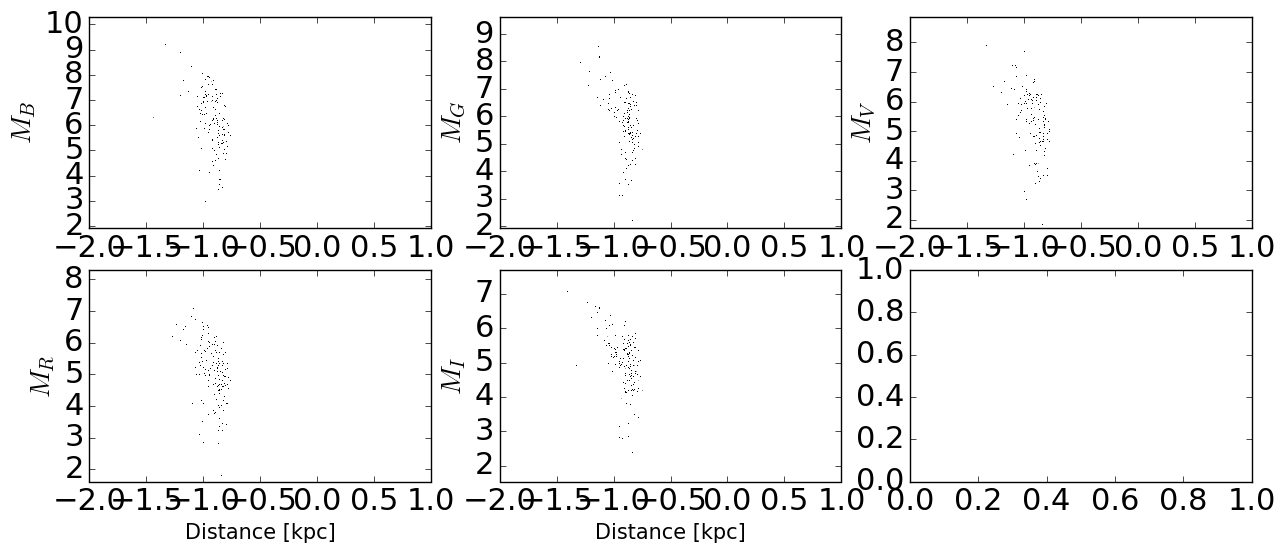

In [18]:
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.ravel()
ylabels = ['$M_B$', '$M_G$', '$M_V$', '$M_R$', '$M_I$']
bands = [M_b, M_g, M_v, M_r, M_i]
for ax, i in zip(axes, np.arange(len(bands))):
    out = ax.hist2d(np.log10(medianDistMatched/1000.), bands[i], bins=500, norm=LogNorm(), cmap=plt.get_cmap('gray'))
    if i in [3, 4]: ax.set_xlabel('Distance [kpc]', fontsize=15)
    ax.set_ylabel(ylabels[i], fontsize=20)
    ax.set_xlim(-2, 1)

In [19]:
tree = kdtree.cKDTree(data=zip(M_b, M_g, M_v, M_r, M_i))

In [20]:
treeColor = kdtree.cKDTree(data=zip(M_v, B_V, g_r, r_i))

In [21]:
def chisq(data, value, error):
    return np.sqrt(np.sum(((data - value)/error)**2.))/len(data)

In [40]:
import pdb
#some magsMatched[matchedInd, sourceInd] have 0.0 error :/

def distMetric(sourceInd, matchedInd, p=False):
    colorChiSq = 0.0
    colors = [B_V, g_r, r_i]
    color_errors = [['e_bmag', 'e_vmag'], ['e_gmag', 'e_rmag'], ['e_rmag', 'e_imag']]
    for color, error in zip(colors, color_errors):
        #print mag, error, sourceInd, matchedInd
        colorChiSq += (color[sourceInd] - color[matchedInd])**2./\
                      (magsMatched[error[0]][sourceInd]**2. + magsMatched[error[1]][sourceInd]**2. + \
                       magsMatched[error[0]][matchedInd]**2.+ magsMatched[error[1]][matchedInd]**2.)
        if p: print colorChiSq
    absMagChiSq = (M_v[sourceInd] - M_v[matchedInd])**2./\
                   (magsMatched['e_vmag'][sourceInd]**2. + magsMatched['e_vmag'][matchedInd]**2. +\
                  (errMatched[sourceInd] *5./np.log(10)*medianDistMatched[sourceInd])**2. +\
                  (errMatched[matchedInd]*5./np.log(10)*medianDistMatched[matchedInd])**2.)
    totChiSq = np.sqrt(colorChiSq + absMagChiSq)
    print 'the total chi2: ',totChiSq
    print 'the color chi2: ' ,colorChiSq
    print 'the absmag chi2:',absMagChiSq
    #if np.sum(np.isinf(totChiSq)): pdb.set_trace()
    return totChiSq

the total chi2:  [ 0.4223734   0.40258523  0.29016776  0.43181179  0.42534823  0.72193564
  0.4925866   0.46796061  0.79845376]
the color chi2:  [ 0.17839928  0.16207486  0.08419728  0.18646139  0.18092105  0.52119106
  0.24264152  0.21898705  0.63752836]
the absmag chi2: [  1.05241957e-08   4.76816444e-10   4.82979680e-08   3.60120399e-08
   6.81973216e-08   6.04190958e-10   3.10340786e-08   8.81090359e-08
   4.09319321e-08]
[ 0.4223734   0.40258523  0.29016776  0.43181179  0.42534823  0.72193564
  0.4925866   0.46796061  0.79845376]
the total chi2:  [ 0.16943735  0.1898767   0.38659403  0.491848    0.45898207  0.41774379
  0.40091359  0.54555126  0.436411  ]
the color chi2:  [ 0.02870902  0.03605315  0.14945494  0.24191445  0.21066454  0.17450985
  0.1607317   0.29762617  0.19045454]
the absmag chi2: [  3.91988343e-10   7.40965579e-09   9.29312247e-09   1.78315743e-09
   1.58540926e-09   1.83810173e-08   2.14523642e-09   6.92543409e-09
   2.11766754e-08]
[ 0.16943735  0.1898767   0.3

/mnt/xfs1/scda_software/pkg/devel/python/2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide


the total chi2:  [        inf         inf         inf  6.69658239         inf  0.53937385
         inf         inf         inf]
the color chi2:  [         inf          inf          inf  44.84421539          inf
   0.29092187          inf          inf          inf]
the absmag chi2: [  2.45695211e-08   7.64099966e-09   2.91670111e-07   2.64215720e-07
   3.18239064e-07   2.28058295e-06   1.89317528e-06   9.67254619e-08
   1.70143509e-06]
[        inf         inf         inf  6.69658239         inf  0.53937385
         inf         inf         inf]
the total chi2:  [ 0.55832499  0.63731381  0.99742198  0.48466794  0.7467517   0.74501167
  0.70734168  1.40145617  1.15047388]
the color chi2:  [ 0.31172675  0.40616888  0.99485058  0.23490289  0.55763805  0.55504233
  0.50033224  1.96407938  1.32359016]
the absmag chi2: [  4.51345641e-08   1.91122540e-08   2.98866502e-08   1.27184016e-07
   5.04359119e-08   5.98376623e-08   2.08437415e-08   8.83651545e-09
   1.91023096e-10]
[ 0.55832499  0.6373

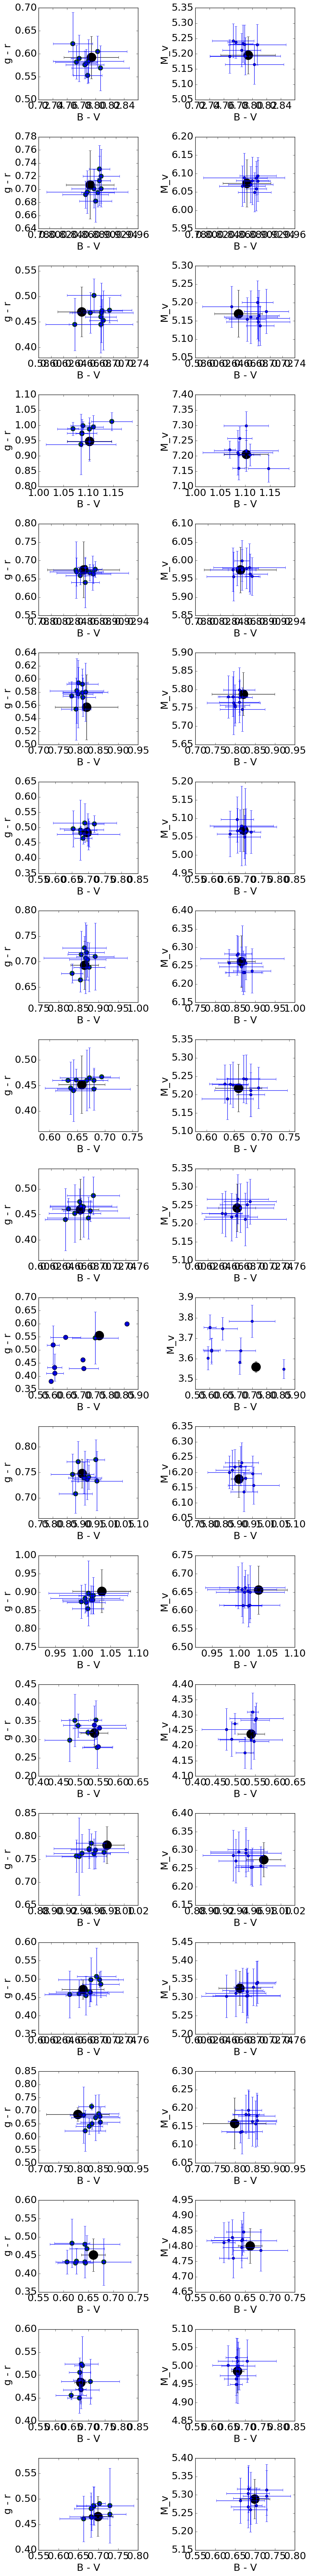

In [41]:
#check ChiSq are what you think they are, correct length, why inf?
sources = []
matches = []
nstars = 20
fig, ax = plt.subplots(nstars, 2, figsize=(10, 80))
axes = itertools.cycle(ax.ravel())
for star in np.arange(nstars): #np.arange(len(M_v)):
    pts = [M_v[star], B_V[star], g_r[star], r_i[star]]
    #errDistance = np.sqrt(np.sum(magsMatched['bmag']**2. + magsMatched['vmag']**2. + \
    #                             magsMatched['gmag']**2. + magsMatched['rmag']**2. + \
    #                             magsMatched['rmag']**2. + magsMatched['imag']**2. + \
    #                             magsMatched['vmag']**2. + (errMatched/tgasMatched['parallax'])**2., 0))
    treeDistNum, treeIndNum = treeColor.query(pts, k=nNeighbors)
    treeIndNum = treeIndNum[1:]
    chisq = distMetric(star, treeIndNum, p=False) 
    print chisq
    colors = np.array(['b',]*len(chisq))
    colors[chisq < 4] = 'g'
    #fig, ax = plt.subplots()
    ax = axes.next()
    ax.errorbar(B_V[star], g_r[star], 
                xerr = np.sqrt(magsMatched['e_bmag'][star]**2. + magsMatched['e_vmag'][star]**2.), 
                yerr = np.sqrt(magsMatched['e_gmag'][star]**2. + magsMatched['e_rmag'][star]**2.), fmt='o', color='black')
    ax.errorbar(B_V[treeIndNum], g_r[treeIndNum], 
                xerr = np.sqrt(magsMatched['e_bmag'][treeIndNum]**2. + magsMatched['e_vmag'][treeIndNum]**2.), 
                yerr = np.sqrt(magsMatched['e_gmag'][treeIndNum]**2. + magsMatched['e_rmag'][treeIndNum]**2.), fmt='o', color='blue')
    ax.scatter(B_V[treeIndNum], g_r[treeIndNum], c=colors, s=100)
    ax.scatter(B_V[star], g_r[star], s=400, c='black')
    ax.set_xlabel('B - V')
    ax.set_ylabel('g - r')

    ax = axes.next()
    ax.errorbar(B_V[star], M_v[star], 
                xerr = np.sqrt(magsMatched['e_bmag'][star]**2. + magsMatched['e_vmag'][star]**2.), 
                yerr = np.sqrt(magsMatched['e_vmag'][star]**2. + \
                               (errMatched[star]/tgasMatched['parallax'][star])**2.), fmt='o', color='black')
    ax.errorbar(B_V[treeIndNum], M_v[treeIndNum], 
                xerr = np.sqrt(magsMatched['e_bmag'][treeIndNum]**2. + magsMatched['e_vmag'][treeIndNum]**2.), 
                yerr = np.sqrt(magsMatched['e_vmag'][treeIndNum]**2. + (errMatched[treeIndNum]/tgasMatched['parallax'][treeIndNum])**2.),
                              fmt='o', color='blue')
    ax.scatter(B_V[star], M_v[star], s=400, c='black')
    ax.set_xlabel('B - V')
    ax.set_ylabel('M_v')
    
    #treeDistDis, treeIndDis = treeColor.query(pts, k=nNeighbors, distance_upper_bound=errDistance)
    #if not np.array_equal(treeIndNum, treeIndDis): print treeIndNum, treeIndDis
    #import pdb; pdb.set_trace()    
    
    #if star<10:print chisq
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sources = []
matches = []
p = False
for star in np.arange(len(M_b)): #np.random.randint(0, len(M_b), len(M_b)):
    pts = [M_b[star], M_g[star], M_v[star], M_r[star], M_i[star]]
    errorDistance = np.sum([magsMatched[e][star]**2. for e in errors])
    #treeInd = tree.query_ball_point(pts, errorDistance) #10.*errorDistance)
    treeDist, treeInd = tree.query(pts, k=nNeighbors, distance_upper_bound=errorDistance*fracErrorDistance)

    if treeInd[1] != len(magsMatched): 
        #print star, treeInd
        #print star, treeDist
        if p: print 'Distance Src: ', "{:.4f}".format(medianDistMatched[star])
        if p: print 'Distance Match: ' + " ".join(["{:.4f}".format(medianDistMatched[j]) for j in treeInd[1:] if j != len(magsMatched)])
        if p: print 'Chisq     :',' '.join(["{:.4f}".format(chisq(np.array([M_b[i],   M_g[i],   M_v[i],   M_r[i],   M_i[i]]), 
                           np.array([M_b[star],M_g[star],M_v[star],M_r[star],M_i[star]]),
                           np.array([magsMatched[e][star] for e in errors])))
                    for i in treeInd[1:] if i != len(magsMatched)])
        if p: print 'Sigma Src :',' '.join(["{:.4f}".format(np.float(magsMatched[e][star])) for e in errors])
        if p: print 'Mags Src  : '+ "{:.4f}".format(M_b[star]) + ' ' + \
                              "{:.4f}".format(M_g[star]) + ' ' + \
                              "{:.4f}".format(M_v[star]) + ' ' + \
                              "{:.4f}".format(M_r[star]) + ' ' + \
                              "{:.4f}".format(M_i[star])    
        for i in treeInd[1:]: 
            if (i != len(magsMatched)) & p: print 'Mags Match: ' + "{:.4f}".format(M_b[i]) + ' ' + \
                                                             "{:.4f}".format(M_g[i]) + ' ' + \
                                                             "{:.4f}".format(M_v[i]) + ' ' + \
                                                             "{:.4f}".format(M_r[i]) + ' ' + \
                                                             "{:.4f}".format(M_i[i])
        if p: print '\n'
        ax.errorbar(wavelength, [M_b[star],M_g[star],M_v[star],M_r[star],M_i[star]],[magsMatched[e][star] for e in errors], color='black', fmt='o')
        for i in treeInd[1:]:
            if i != len(magsMatched): ax.scatter(wavelength, [M_b[i],M_g[i],M_v[i],M_r[i],M_i[i]], s=100, color='green')
        sources.append(star)
        matches.append(treeInd[1:][treeInd[1:] != len(magsMatched)])
ax.set_ylabel('Absolute Magnitude', fontsize=25)
ax.set_xlabel('wavelength [nm]', fontsize=25)
plt.gca().invert_yaxis()
plt.savefig('stellarTwins.png')

In [ ]:
print sources, matches

In [ ]:
for s, m in zip(sources, matches): print np.sum(np.in1d(tgasRave['source_id'], tgasMatched[s]['source_id'])) + np.sum(np.in1d(tgasRave['source_id'], tgasMatched[m]['source_id']))

In [ ]:
for s, m in zip(sources, matches): print np.where(np.in1d(tgasRave['source_id'], tgasMatched[s])), \
    np.where(np.in1d(tgasRave['source_id'], tgasMatched[m]['source_id']))

In [ ]:
indices = []
for s, m in zip(sources, matches): indices.append(np.concatenate((np.where(np.in1d(tgasRave['source_id'], tgasMatched[s]['source_id']))[0], \
                                                                  np.where(np.in1d(tgasRave['source_id'], tgasMatched[m]['source_id']))[0])))
print indices

In [ ]:
fig, axes = plt.subplots(len(indices)/3 + 1, 3, figsize=(15, 60))
axes = axes.ravel()
for ax, i in zip(axes, indices):
    ax.errorbar(tgasRave['TEFF'][i]/1000., tgasRave['LOGG'][i], xerr=tgasRave['E_TEFF'][i]/1000., yerr=tgasRave['E_LOGG'][i],
               fmt='o', color='black')
    ax.set_ylabel('log g', fontsize=15)
    ax.set_xlabel('Teff', fontsize=15)
    ax.set_xlim(4.5, 7)
    ax.set_ylim(3, 5)
    ax.grid()
plt.show()

In [ ]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 25}) 
for j, i in enumerate(indices):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.errorbar(tgasRave['TEFF'][i]/1000., tgasRave['LOGG'][i], xerr=tgasRave['E_TEFF'][i]/1000., yerr=tgasRave['E_LOGG'][i],
               fmt='o', color='black')
    ax.set_ylabel('log g')
    ax.set_xlabel('Teff [kK]')
    ax.set_xticks([5, 6, 7])
    ax.set_xlim(4.5, 7)
    ax.set_ylim(3, 5)
    ax.grid()
    plt.tight_layout()
    fig.savefig('stellarTwins.' + str(j) + '.png')

In [ ]:
for i in indices:
    for j in i:
        text = 'Tycho2 Id: ' + str(tgasRave[j]['tycho2_id']) + '\n' + \
       'pmra: ' + "{:.2f}".format(np.float(tgasRave[j]['pmra'])) + '\n' + \
       'pmdc: ' + "{:.2f}".format(np.float(tgasRave[j]['pmdec'])) + '\n' + \
       'vrad: ' + "{:.2f}".format(np.float(tgasRave[j]['HRV']))
        print text